In [1]:
%env CUDA_VISIBLE_DEVICES=7
%env OMP_NUM_THREADS=2

env: CUDA_VISIBLE_DEVICES=7
env: OMP_NUM_THREADS=2


In [3]:
import sys
import os

sys.path.extend(['/home/jorg/repo/aesr'])
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm

import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import SimpleITK as sitk
try:
    from skimage.measure import compare_ssim as ssim_metric
    from skimage.measure import compare_psnr as psnr_metric
except ImportError:
    from skimage.metrics import structural_similarity as ssim_metric
    from skimage.metrics import peak_signal_noise_ratio as psnr_metric

from datasets.data_config import get_config
from datasets.shared_transforms import CenterCrop, AdjustToPatchSize
from kwatsch.get_trainer import get_trainer
from evaluate.create_HR_images import create_hr_images
from evaluate.brain.evaluate_model import create_brain_volumes
from evaluate.brain.evaluate_model import create_brain_volumes_conventional_interpolation
from kwatsch.common import load_settings
%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.manual_seed(32563)
rs = np.random.RandomState(32563)
ttest_results = {}

print("Ready")

Ready


In [8]:
# ae/mse_baseline_p64_ex01  ae/mse_baseline_ex01  mse_baseline_3mm_ex01
# ae_combined/mse_perc_p64_ex01
# ae_combined/mse_perc_p32_ex02    ae_combined/mse_perc_p32_3mm
dataset = 'dHCP' 
eval_patch_size = {'dHCP': 256, 'ADNI': 256, 'OASIS': 220}[dataset]
model_nbr = 605 #  combined: dHCP: 1272  OASIS: 3mm 1298  OASIS: 2mm 507
pat_list = [31800]  # =None
model_nbr_sr =  None  # 836
output_dir = None
eval_axis = 1
exper_dir = "pool2_w256_l16_2mm_w001_ex01"
exper_src_path = "~/expers/sr_redo/{}/ae_combined/{}".format(dataset, exper_dir)
myargs = load_settings(os.path.join(os.path.expanduser(exper_src_path), "settings.yaml"))
save_volumes = True 
do_save_metrics = False
generate_inbetween_slices = False
use_original_slice = False
downsample_steps = myargs['downsample_steps']
num_interpolations = downsample_steps - 1
if not generate_inbetween_slices:
    num_interpolations = 6
    # IMPORTANT FOR BRAIN MRI WE USE THE DOWNSAMPLED VOLUMES EVEN WHEN USING HIGHER 
    # UPSAMPLING FACTORS THAN DURING TRAINING !!!
    downsample_steps = myargs['downsample_steps']
    output_dir = exper_src_path + "/ni{:02d}".format(num_interpolations)
print("Eval patch size ", eval_patch_size)
metrics_dict = create_brain_volumes(exper_src_path, model_nbr, pat_list=pat_list,
                                    # pat_list=[31800], 
                                   generate_inbetween_slices=generate_inbetween_slices,
                                   downsample_steps=downsample_steps, 
                                    save_volumes=save_volumes,
                                    eval_patch_size=eval_patch_size,
                                   num_interpolations=num_interpolations,
                                   compute_percept_loss=False, 
                                   use_original_slice=use_original_slice,
                                   eval_axis=eval_axis, model_nbr_sr=model_nbr_sr,
                                   output_dir=output_dir,
                                   do_save_metrics=do_save_metrics)

Eval patch size  256
INFO - Initializing trainer AETrainerExtension1Brain - using multiple gpus False
Warning - Base Trainer - LPIPS on GPU-ID 0
Warning - LPIPS weights [1.0, 1.0, 1.0, 1.0, 1.0] 
Loading model from: /home/jorg/repo/aesr/lpips/weights/v0.1/vgg.pth
INFO - AETrainerExtension1Brain Loaded model parameters from /home/jorg/expers/sr_redo/dHCP/ae_combined/pool2_w256_l16_2mm_w001_ex01/models/605.models
WARNING WARNING - you are using VanillaACAI CAE class
INFO - get_images - using file suffix for search t2w_2.0mm.nii.gz


Loading 1 volumes from /home/jorg/data/dHCP_cropped_256:   0%|          | 0/1 [00:00<?, ?it/s]

[202. 256. 256.]
WARNING - Current model-nbr >>> 605 <<< train patch-size/test patch-size 256/256
INFO - evaluating on 1 patients
!!! Warning !!! Generation 6 new slices and mimick LR volumes with downsampling factor 4
{'ae_class': 'VanillaACAI', 'alpha_class': None, 'alpha_loss_func': None, 'aug_patch_size': None, 'batch_size': 8, 'colors': 1, 'comment': None, 'dataset': 'dHCP', 'depth': 32, 'device': 'cuda', 'downsample_steps': 4, 'epochs': 750, 'ex_loss_weight1': 0.001, 'exper_id': 'pool2_w256_l16_2mm_w001_ex01', 'fine_tune': False, 'get_masks': False, 'gpu_ids': [0], 'image_mix_loss_func': 'perceptual', 'latent': 16, 'latent_width': 64, 'limited_load': False, 'lr': 1e-05, 'max_grad_norm': 0, 'model': 'ae_combined', 'model_filename': None, 'module_network_path': 'networks/acai_vanilla.py', 'module_trainer_path': 'kwatsch/brain/trainer_ae.py', 'n_res_block': None, 'number_of_workers': 2, 'output_dir': '/home/jorg/expers/sr_redo/dHCP/ae_combined/pool2_w256_l16_2mm_w001_ex01', 'port': 

In [18]:
from kwatsch.get_trainer import get_trainer_dynamic
trainer, myargs = get_trainer_dynamic(src_path=exper_src_path, 
                                      model_nbr=model_nbr, 
                                      model_nbr_sr=model_nbr_sr)

INFO - Initializing trainer AETrainerExtension1Brain - using multiple gpus False
Warning - Base Trainer - LPIPS on GPU-ID 0
Warning - LPIPS weights [1.0, 1.0, 1.0, 1.0, 1.0] 
Loading model from: /home/jorg/repo/aesr/lpips/weights/v0.1/vgg.pth
INFO - AETrainerExtension1Brain Loaded model parameters from /home/jorg/expers/sr_redo/dHCP/ae_combined/pool2_w256_l16_1mm_w001_ex01/models/652.models
WARNING WARNING - you are using VanillaACAI CAE class


In [28]:
from datasets.common_brains import get_images
import SimpleITK as sitk

f = "/home/jorg/data/dHCP_cropped_256/012501/012501_t2w_3.0mm.nii.gz" 
img = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f))).float()
print(img.shape)

torch.Size([202, 256, 256])


In [30]:
from evaluate.common import create_super_volume


downsample_steps = 6
num_interpolations = downsample_steps - 1
alpha_range = np.linspace(0, 1, num_interpolations + 2, endpoint=True)[1:-1]
%timeit new_img = create_super_volume(trainer, img, alpha_range=alpha_range, use_original=False, downsample_steps=downsample_steps, hierarchical=False,generate_inbetween_slices=True,train_patch_size=256,feature_dict=None,  labels=None)


638 ms ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#                             SSIM / PSRN / VIF / LPIPS:
#   ae-combined 4mm   (264)   0.933 (0.01) / 35.41 (0.55) / 0.858 (0.01) / 0.000 (0.00)
#   ae 4mm                    0.948 (0.00) / 35.26 (0.53) / 0.841 (0.01) / 0.000 (0.00)
#   ae-combined 5mm           0.908 (0.01) / 32.77 (0.58) / 0.847 (0.01) / 0.000 (0.00)
#   ae 5mm                    0.910 (0.01) / 32.79 (0.57) / 0.863 (0.01) / 0.000 (0.00)

In [ ]:
0.969 (0.00) / 36.37 (0.85) / 0.867 (0.01) / 0.000 (0.00)

In [8]:
from evaluate.brain.evaluate_model import create_brain_volumes_conventional_interpolation

dataset = 'dHCP'
eval_patch_size = {'dHCP': 256, 'ADNI': 256, 'OASIS': 220}[dataset]
# interpol_filter = "lanczos"  #   bspline  lanczos, linear nearest
# downsample_steps = 4
# expand_factor = downsample_steps
save_volumes = True
output_dir = os.path.expanduser('~/expers/sr/{}/conventional'.format(dataset))
for downsample_steps in [2]:
    expand_factor = downsample_steps
    for interpol_filter in ['bspline', 'linear', 'lanczos']:
        metrics_dict = create_brain_volumes_conventional_interpolation(dataset, interpol_filter,  
                                                                      expand_factor=expand_factor,
                                                           eval_patch_size=eval_patch_size, 
                                                                       save_volumes=save_volumes, 
                                                           downsample_steps=downsample_steps,
                                                           compute_percept_loss=False,
                                                           use_original_slice=False, 
                                                           generate_inbetween_slices=True,
                                                           num_interpolations=None,
                                                           output_dir=output_dir,
                                                                      do_save_metrics=True)

INFO - get_images - using file suffix for search t2w_1.0mm.nii.gz


Loading 20 volumes from /home/jorg/data/dHCP_cropped_256:   0%|          | 0/20 [00:00<?, ?it/s]

[198.45 256.   256.  ]
WARNING - Creating volumes with conventional interpolation method bspline - eval-patch-size 256 - expand factor 2 - downsample steps 2 
INFO - evaluating on 20 patients
INFO - saving output to /home/jorg/expers/sr/dHCP/conventional/bspline
INFO - saved /home/jorg/expers/sr/dHCP/conventional/bspline/12501/12501_ni01.nii.gz
SSIM / PSRN / VIF: 0.986 / 36.723 / 0.864
INFO - saved /home/jorg/expers/sr/dHCP/conventional/bspline/13801/13801_ni01.nii.gz
SSIM / PSRN / VIF: 0.986 / 37.407 / 0.867
INFO - saved /home/jorg/expers/sr/dHCP/conventional/bspline/18600/18600_ni01.nii.gz
SSIM / PSRN / VIF: 0.988 / 37.226 / 0.873
INFO - saved /home/jorg/expers/sr/dHCP/conventional/bspline/26300/26300_ni01.nii.gz
SSIM / PSRN / VIF: 0.986 / 35.690 / 0.863
INFO - saved /home/jorg/expers/sr/dHCP/conventional/bspline/26700/26700_ni01.nii.gz
SSIM / PSRN / VIF: 0.989 / 38.930 / 0.881
INFO - saved /home/jorg/expers/sr/dHCP/conventional/bspline/31800/31800_ni01.nii.gz
SSIM / PSRN / VIF: 0.98

Loading 20 volumes from /home/jorg/data/dHCP_cropped_256:   0%|          | 0/20 [00:00<?, ?it/s]

[198.45 256.   256.  ]
WARNING - Creating volumes with conventional interpolation method linear - eval-patch-size 256 - expand factor 2 - downsample steps 2 
INFO - evaluating on 20 patients
INFO - saving output to /home/jorg/expers/sr/dHCP/conventional/linear
INFO - saved /home/jorg/expers/sr/dHCP/conventional/linear/12501/12501_ni01.nii.gz
SSIM / PSRN / VIF: 0.984 / 36.402 / 0.863
INFO - saved /home/jorg/expers/sr/dHCP/conventional/linear/13801/13801_ni01.nii.gz
SSIM / PSRN / VIF: 0.984 / 37.044 / 0.865
INFO - saved /home/jorg/expers/sr/dHCP/conventional/linear/18600/18600_ni01.nii.gz
SSIM / PSRN / VIF: 0.986 / 36.881 / 0.871
INFO - saved /home/jorg/expers/sr/dHCP/conventional/linear/26300/26300_ni01.nii.gz
SSIM / PSRN / VIF: 0.984 / 35.504 / 0.864
INFO - saved /home/jorg/expers/sr/dHCP/conventional/linear/26700/26700_ni01.nii.gz
SSIM / PSRN / VIF: 0.988 / 38.595 / 0.878
INFO - saved /home/jorg/expers/sr/dHCP/conventional/linear/31800/31800_ni01.nii.gz
SSIM / PSRN / VIF: 0.985 / 36.9

Loading 20 volumes from /home/jorg/data/dHCP_cropped_256:   0%|          | 0/20 [00:00<?, ?it/s]

[198.45 256.   256.  ]
WARNING - Creating volumes with conventional interpolation method lanczos - eval-patch-size 256 - expand factor 2 - downsample steps 2 
INFO - evaluating on 20 patients
INFO - saving output to /home/jorg/expers/sr/dHCP/conventional/lanczos
INFO - saved /home/jorg/expers/sr/dHCP/conventional/lanczos/12501/12501_ni01.nii.gz
SSIM / PSRN / VIF: 0.986 / 36.636 / 0.866
INFO - saved /home/jorg/expers/sr/dHCP/conventional/lanczos/13801/13801_ni01.nii.gz
SSIM / PSRN / VIF: 0.986 / 37.298 / 0.867
INFO - saved /home/jorg/expers/sr/dHCP/conventional/lanczos/18600/18600_ni01.nii.gz
SSIM / PSRN / VIF: 0.988 / 37.140 / 0.874
INFO - saved /home/jorg/expers/sr/dHCP/conventional/lanczos/26300/26300_ni01.nii.gz
SSIM / PSRN / VIF: 0.986 / 35.579 / 0.862
INFO - saved /home/jorg/expers/sr/dHCP/conventional/lanczos/26700/26700_ni01.nii.gz
SSIM / PSRN / VIF: 0.989 / 38.801 / 0.883
INFO - saved /home/jorg/expers/sr/dHCP/conventional/lanczos/31800/31800_ni01.nii.gz
SSIM / PSRN / VIF: 0.98

In [ ]:
# 0.965 (0.00) / 32.84 (0.85) / 0.829 (0.01) / 0.000 (0.00)

In [25]:
from evaluate.brain.evaluate_model import get_test_dataset
from evaluate.find_best_model import find_best_val_model
from kwatsch.get_trainer import get_trainer_dynamic
from datasets.OASIS.dataset import get_oasis_patient_ids
from datasets.dHCP.create_dataset import get_patient_ids as get_dHCP_patient_ids
from datasets.data_config import get_config

dataset = "dHCP"   # or "MASI"  "dHCP"  'OASIS'
dataset_config = get_config(dataset)
downsample_steps = 3
eval_axis = 0                         # ae/mse_baseline_p16_l128_3mm_blur_ex01
epoch_range=np.arange(602,700, 1)  #  mse_perc_p16_l128_2mm_w005_ex02
epoch_range = [651, 670, 610]
exper_id = "~/expers/sr/{}/ae_combined/mse_perc_p16_l16_1_5mm_blur_ex01".format(dataset)
patid_list = get_oasis_patient_ids("validation")[::2] if dataset == "OASIS" else \
                get_dHCP_patient_ids("validation", dataset_config.image_dir)
print("!!!!! WARNING - patid list is not empty len({})".format(len(patid_list)))
patid = None
eval_patch_size = {'dHCP': 256, 'brainMASI': 256, 'OASIS': 220}[dataset]
images_test, _ = get_test_dataset(dataset, patient_id=None, downsample=False,
                                  downsample_steps=downsample_steps,
                                  type_of_set="validation", patch_size=eval_patch_size,
                                  include_hr_images=True, patid_list=patid_list)
print("Evaluating on dataset {}".format(dataset))

patient_id = None
result_dict = find_best_val_model(images_test, 
                        exper_id, 
                        epoch_range, ps_evaluate=eval_patch_size, eval_axis=eval_axis,
                        downsample_steps=downsample_steps, patient_id=patient_id,
                        limit_4d=False, func_get_trainer=get_trainer_dynamic)

!!!!! WARNING - patid list is not empty len(10)
INFO - get_images - using file suffix for search t2w_1.5mm.nii.gz


Loading 10 volumes from /home/jorg/data/dHCP_cropped_256:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating on dataset dHCP
INFO - find-best-validation-model - testing 3 networks using p-size 256  - eval_axis=0
INFO - AETrainerExtension1Brain - model is in eval mode True
INFO - AETrainerExtension1Brain Loaded model parameters from /home/jorg/expers/sr/dHCP/ae_combined/mse_perc_p16_l16_1_5mm_blur_ex01/models/651.models
WARNING WARNING - you are using VanillaACAI CAE class
Total - SSIM / PSRN / VIF / LPIPS: 0.973 (0.00) / 35.19 (1.17) / 0.847 (0.02) / 0.000 (0.00)
Synthesis - SSIM / PSRN / VIF / LPIPS: 0.966 (0.00) / 33.55 (0.97) / 0.837 (0.02) / 0.000 (0.00)
INFO - AETrainerExtension1Brain - model is in eval mode True
INFO - AETrainerExtension1Brain Loaded model parameters from /home/jorg/expers/sr/dHCP/ae_combined/mse_perc_p16_l16_1_5mm_blur_ex01/models/670.models
WARNING WARNING - you are using VanillaACAI CAE class
Total - SSIM / PSRN / VIF / LPIPS: 0.970 (0.00) / 35.60 (1.17) / 0.858 (0.02) / 0.000 (0.00)
Synthesis - SSIM / PSRN / VIF / LPIPS: 0.964 (0.00) / 33.77 (0.96) / 0.84

In [17]:
from evaluate.find_best_model import load_model_scores

dataset = 'dHCP'
file_suffix = "_axis0.npz"
synthesis = True
exper_dir = "~/expers/sr_redo/{}/ae_combined/pool2_w64_l16_1mm_w001_ex01".format(dataset)
results, iters, ssim_res, psnr_res, vif_res = \
            load_model_scores(exper_dir, file_suffix=file_suffix, 
                              synthesis=synthesis)

INFO - searching with mask /home/jorg/expers/sr_redo/dHCP/ae_combined/pool2_w64_l16_1mm_w001_ex01/model_perf*_axis0.npz
INFO - loading /home/jorg/expers/sr_redo/dHCP/ae_combined/pool2_w64_l16_1mm_w001_ex01/model_perf_1200_to_1300_axis0.npz


In [15]:
idx_psnr, idx_ssim, idx_vif = np.argmax(psnr_res), np.argmax(ssim_res), np.argmax(vif_res)
print("SSIM ({}): {:.3f}".format(iters[idx_ssim], ssim_res[idx_ssim]))
print("PSNR ({}): {:.3f}".format(iters[idx_psnr], psnr_res[idx_psnr]))
print("VIF ({}): {:.3f}".format(iters[idx_vif], vif_res[idx_vif]))
print("M-{}: {:.3f}, {:.3f}, {:.3f}".format(iters[idx_ssim], ssim_res[idx_ssim],
                                          psnr_res[idx_ssim], vif_res[idx_ssim]))
print("M-{}: {:.3f}, {:.3f}, {:.3f}".format(iters[idx_psnr], ssim_res[idx_psnr],
                                          psnr_res[idx_psnr], vif_res[idx_psnr]))
print("M-{}: {:.3f}, {:.3f}, {:.3f}".format(iters[idx_vif], ssim_res[idx_vif],
                                          psnr_res[idx_vif], vif_res[idx_vif]))

SSIM (1202): 0.987
PSNR (1266): 38.128
VIF (1264): 0.887
M-1202: 0.987, 37.941, 0.854
M-1266: 0.985, 38.128, 0.861
M-1264: 0.972, 38.113, 0.887


In [8]:
from datasets.dHCP.create_dataset import get_patient_ids
from datasets.OASIS.dataset import get_oasis_patient_ids
from datasets.ADNI.dataset import get_patient_ids as get_patient_ids_adni
from collections import defaultdict
from datasets.common_brains import get_images
from datasets.common import get_images_in_dir

dataset = 'ADNI'
transform256 = transforms.Compose([AdjustToPatchSize(tuple((256, 256)))])
data_config = get_config(dataset)
patid_list = get_patient_ids_adni("test", data_config.image_dir)
method_path, result_dict = {}, {}
data_conv = defaultdict(dict)
downsample_steps = 6
file_suffix = "_ni0{}.nii.gz".format(downsample_steps -1)
EXPER_SRC_DIR = os.path.expanduser("~/expers/sr/{}".format(dataset))
image_ref = get_images(patid_list, dataset, rescale_int=True, int_perc=tuple((0, 100)), 
                       limited_load=False, do_downsample=False, downsample_steps=downsample_steps, 
                       transform=None, include_hr_images=True)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.



[256.  240.  195.2]


In [17]:
exper_id = {6: "ae_combined/pool2_w64_l128_w001_6mm_ex01"}[downsample_steps]
EXPER_SRC_DIR = os.path.expanduser("~/expers/sr_redo/{}".format(dataset))
path_method = os.path.join(EXPER_SRC_DIR, "{}/images_sr_ip".format(exper_id))
data_generator = get_images_in_dir(path_method, dataset_name=dataset,
                                      file_suffix=file_suffix, 
                                      rescale_int=False, 
                                      do_downsample=False,
                                      downsample_steps=None, patid_list=None)
print("Loaded from {} volumes from {} ({})".format(len(data_generator), exper_id,
                                                   file_suffix))
method_path['ae_combined'] = os.path.join(EXPER_SRC_DIR, "{}".format(exper_id))

INFO - get_images_in_dir - dataset name ADNI (#50). Resample-inplane False
Loaded from 50 volumes from ae_combined/pool2_w64_l128_w001_6mm_ex01 (_ni05.nii.gz)


In [19]:
from evaluate.quantitative_comparison import compare_quantitative


method = 'ae_combined'
eval_axis = 0
lpips = None
do_save = True
result_dict[method] = compare_quantitative(image_ref, data_generator, method, 
                                           downsample_steps=downsample_steps, 
                                           transform=transform256,
                     is_4d=False, percept_criterion=lpips, do_save=do_save,
                     method_dir=method_path[method], eval_axis=eval_axis)

INFO - evaluating ae_combined images from /home/jorg/expers/sr_redo/ADNI/ae_combined/pool2_w64_l128_w001_6mm_ex01
INFO - evaluation axis-0 - method: ae_combined - is conventional False - downsample steps 6



ae_combined: SSIM / PSRN / LPIPS / VIF: 0.928 (0.01) / 31.02 (1.70) / 0.000 (0.00) / 0.773 (0.04)
ae_combined (recon): SSIM / PSRN / LPIPS / VIF: 0.940 (0.01) / 31.64 (1.83) / 0.000 (0.00) / 0.769 (0.05)
ae_combined (synth): SSIM / PSRN / LPIPS / VIF: 0.926 (0.01) / 30.89 (1.68) / 0.000 (0.00) / 0.774 (0.04)
INFO - Saved results to /home/jorg/expers/sr_redo/ADNI/ae_combined/pool2_w64_l128_w001_6mm_ex01/results/ae_combined_6x.npz


1216 1226 1231


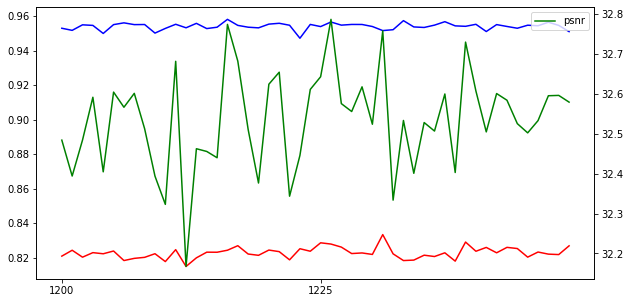

In [8]:
fig = plt.figure(figsize=(10, 5))
print(epochs[np.argmax(ssim)], epochs[np.argmax(psnr)], epochs[np.argmax(vif)])
x_range = np.arange(epochs[0], epochs[-1]+1, 25)
plt.plot(epochs, ssim, label='ssim', c='b')
plt.plot(epochs, vif, label='vif', c='r')
ax2 = plt.twinx()
ax2.plot(epochs, psnr, label='psnr', c='g')
plt.legend(loc="best")
plt.xticks(x_range)
plt.show()

In [6]:
from kwatsch.base_trainer import BaseTrainer, show_loss_curves

path_to_exper = "~/expers/sr_redo/dHCP/ae_combined/mse_perc_pool2_w32_l16_w001_ex01"
iters, losses_train, losses_test = BaseTrainer.load_losses(path_to_exper)

1300 dict_keys(['loss_ae_dist', 'loss_ae_dist_extra', 'loss_ae', 'loss_latent_1'])


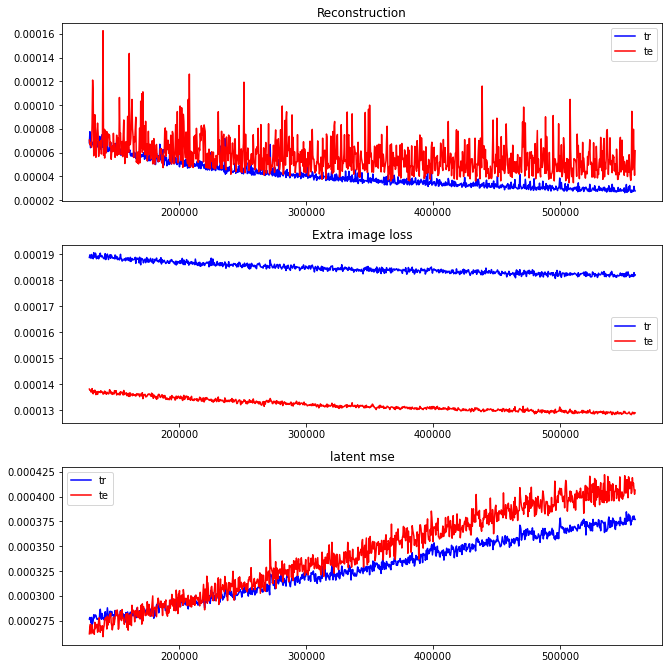

In [14]:
print(len(iters), losses_train.keys())

e_range = slice(len(iters) - 1000, len(iters), None)
show_loss_curves(iters, losses_train, losses_test, e_range)

In [66]:
from datasets.dHCP.dataset import create_lr_dataset_dHCP

create_lr_dataset_dHCP(4, False)

WARNING - common_brains.get_images - retrieving HR images for dHCP



new file  /home/jorg/data/dHCP_cropped_256/000530/000530_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/000900/000900_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/001100/001100_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/001800/001800_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/006210/006210_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/009310/009310_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/011300/011300_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/012110/012110_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/012501/012501_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/013801/013801_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/015102/015102_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/015810/015810_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/017610/017610_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_croppe

new file  /home/jorg/data/dHCP_cropped_256/109600/109600_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/111400/111400_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/111500/111500_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/111700/111700_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/112100/112100_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/113001/113001_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/113900/113900_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/114900/114900_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/115700/115700_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/116000/116000_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/118500/118500_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/118700/118700_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/118800/118800_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped

new file  /home/jorg/data/dHCP_cropped_256/222201/222201_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/223701/223701_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/223800/223800_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/224100/224100_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/229500/229500_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/231702/231702_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/231800/231800_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/232701/232701_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/236400/236400_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/238000/238000_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/238600/238600_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/240700/240700_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped_256/243000/243000_t2w_2.0mm.nii.gz
new file  /home/jorg/data/dHCP_cropped

In [13]:
fname = '/home/jorg/expers/sr/OASIS/ae_combined/mse_perc_p16_l128_3mm_blur_ex01/images_sr_ip/OAS1_0404_MR1/OAS1_0404_MR1_ni02.nii.gz'
img = sitk.ReadImage(fname)
print(img.GetSize())

(220, 220, 176)
